In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.utils import resample
import joblib


In [31]:
df=pd.read_csv('/content/pivotpath_expanded_with_freshers.csv')
df.head()

,current_job_title,target_job_title,skills,education_level,years_of_experience,portfolio_strength,estimated_salary_usd,certifications,language_proficiency,remote_work_preference,projects_completed,communication_skills_rating
0,Data Analyst,Data Scientist,"SQL, Python, Excel, Tableau",Bachelor's in Statistics,3,Medium,85000,Microsoft Azure,"English, Spanish",Onsite,10,5
1,Web Developer,Frontend Engineer,"HTML, CSS, JavaScript, React",Bachelor's in Computer Science,2,High,78000,DataCamp Track,"English, German",Remote,10,4
2,Technical Support Specialist,System Administrator,"Linux, Networking, Shell Scripting",Associate Degree in IT,4,Medium,62000,Microsoft Azure,"English, Spanish",Hybrid,2,5
3,Graphic Designer,UI/UX Designer,"Adobe XD, Figma, Photoshop, Illustrator",Bachelor's in Design,5,High,75000,Certified UX Designer,"English, German",Hybrid,9,5
4,Business Analyst,Product Manager,"JIRA, Excel, SQL, Communication",MBA,6,Medium,95000,Google Data Analytics,"English, German",Onsite,10,3


In [32]:
df.shape

(1100, 12)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   current_job_title            1100 non-null   object
 1   target_job_title             1100 non-null   object
 2   skills                       1100 non-null   object
 3   education_level              1100 non-null   object
 4   years_of_experience          1100 non-null   int64 
 5   portfolio_strength           1100 non-null   object
 6   estimated_salary_usd         1100 non-null   int64 
 7   certifications               998 non-null    object
 8   language_proficiency         1100 non-null   object
 9   remote_work_preference       1100 non-null   object
 10  projects_completed           1100 non-null   int64 
 11  communication_skills_rating  1100 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 103.3+ KB


In [34]:
df.isnull().sum()

,0
current_job_title,0
target_job_title,0
skills,0
education_level,0
years_of_experience,0
portfolio_strength,0
estimated_salary_usd,0
certifications,102
language_proficiency,0
remote_work_preference,0


In [35]:
df.duplicated().sum()

np.int64(0)

In [36]:
df.dropna(inplace=True)
df.isnull().sum()


,0
current_job_title,0
target_job_title,0
skills,0
education_level,0
years_of_experience,0
portfolio_strength,0
estimated_salary_usd,0
certifications,0
language_proficiency,0
remote_work_preference,0


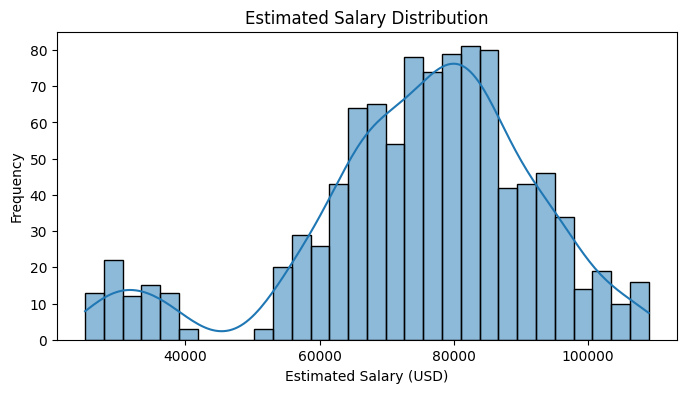

In [37]:
plt.figure(figsize=(8, 4))
sns.histplot(df['estimated_salary_usd'], bins=30, kde=True)
plt.title('Estimated Salary Distribution')
plt.xlabel('Estimated Salary (USD)')
plt.ylabel('Frequency')
plt.show()

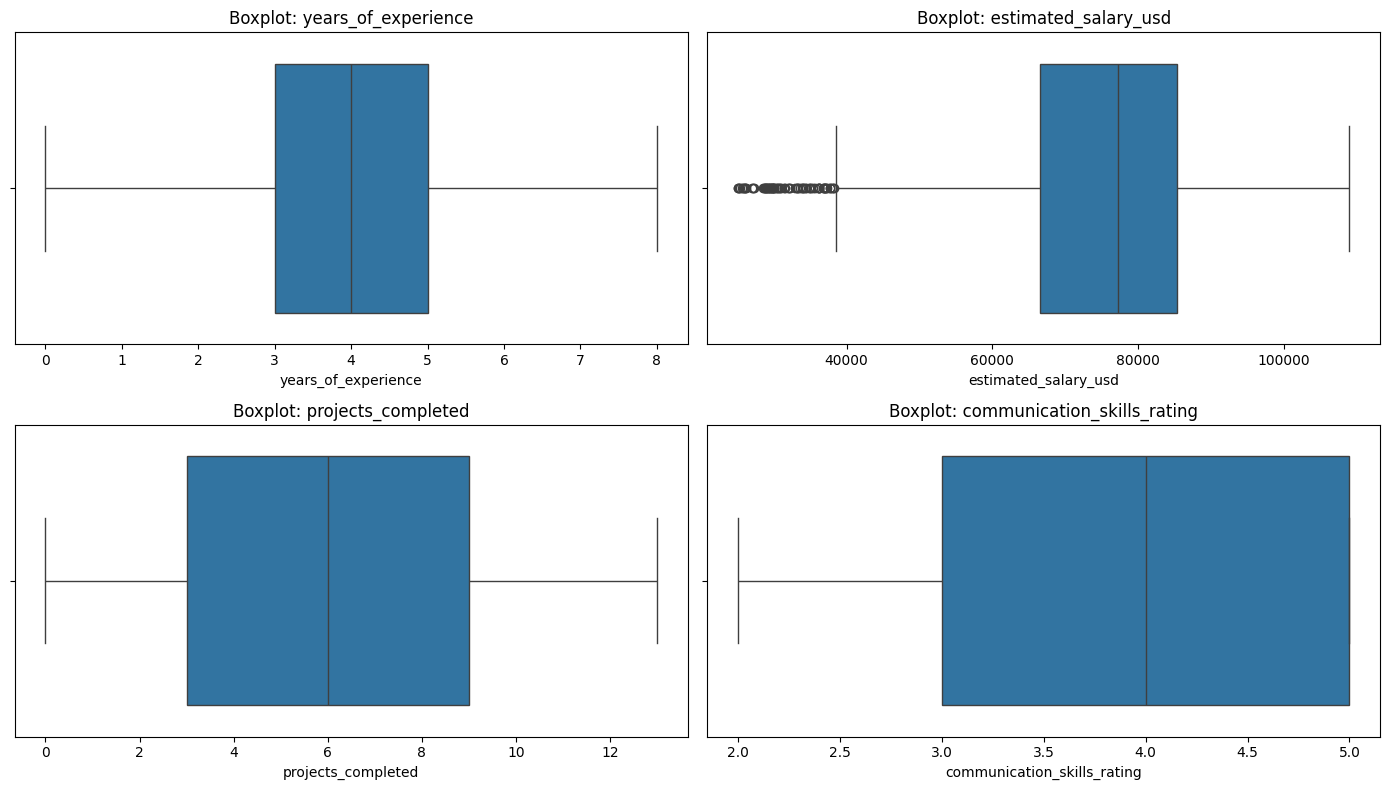

In [38]:
numeric_cols = ['years_of_experience', 'estimated_salary_usd', 'projects_completed', 'communication_skills_rating']
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

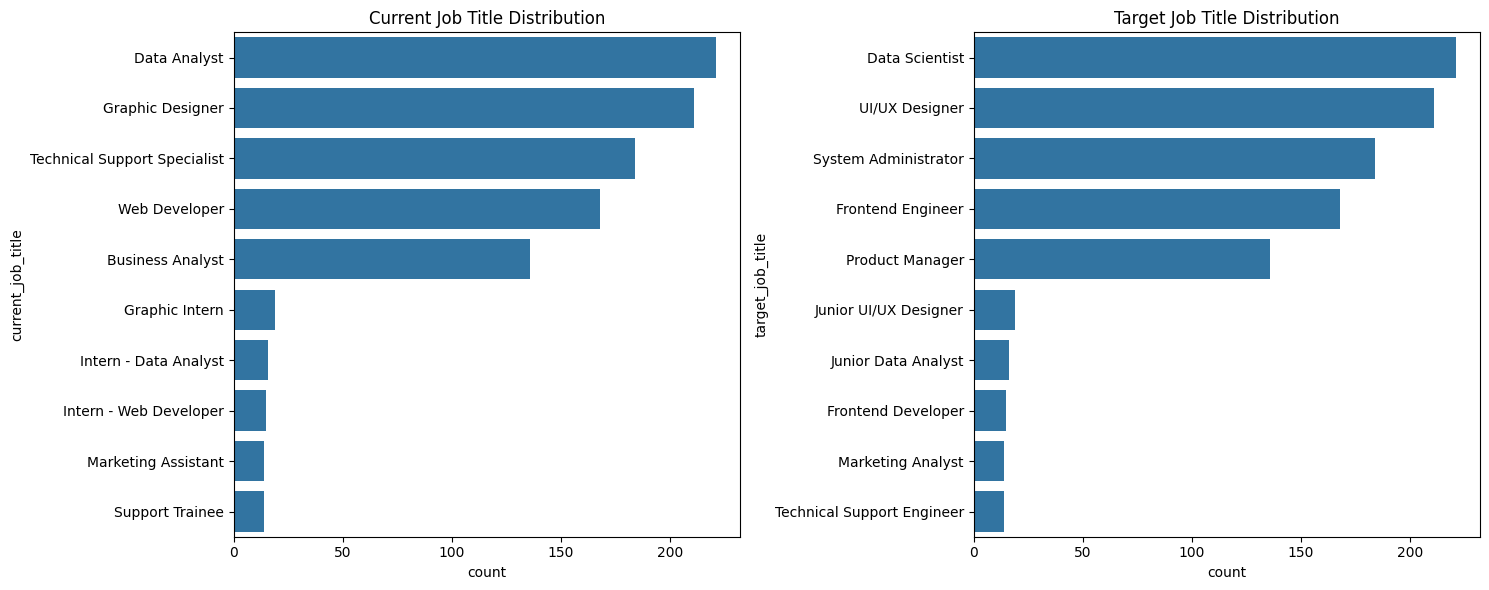

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(y=df['current_job_title'], order=df['current_job_title'].value_counts().index, ax=axs[0])
axs[0].set_title('Current Job Title Distribution')
sns.countplot(y=df['target_job_title'], order=df['target_job_title'].value_counts().index, ax=axs[1])
axs[1].set_title('Target Job Title Distribution')
plt.tight_layout()
plt.show()

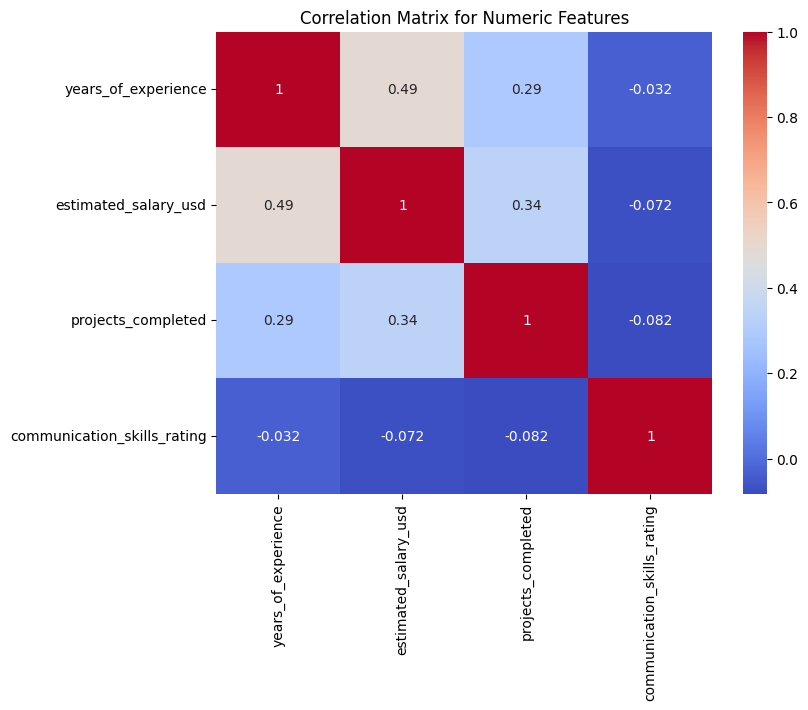

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.show()


In [41]:
# Outlier Detection and Removal
numeric_cols_outliers = ['years_of_experience', 'estimated_salary_usd', 'projects_completed', 'communication_skills_rating']
original_size = len(df)
for col in numeric_cols_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
print(f"Removed {original_size - len(df)} outliers ({100*(len(df)/original_size):.1f}% data kept)")

Removed 74 outliers (92.6% data kept)


In [42]:

# Label Encoding for Categorical Columns
categorical_cols = [
    'education_level',
    'portfolio_strength',
    'certifications',
    'language_proficiency',
    'remote_work_preference'
]

encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
    joblib.dump(le, f"{col}_encoder.pkl")

# Encode job titles
le_current_job = LabelEncoder()
df['current_job_title'] = le_current_job.fit_transform(df['current_job_title'])

le_target_job = LabelEncoder()
df['target_job_title'] = le_target_job.fit_transform(df['target_job_title'])

df.rename(columns={'skills': 'skill_level'}, inplace=True)
df['skill_level'] = df['skill_level'].apply(lambda x: len(str(x).split(',')))

print("Skill level converted successfully:", df['skill_level'].head())



Skill level converted successfully: 0    4
1    4
2    3
3    4
4    4
Name: skill_level, dtype: int64


In [43]:
# --- SAVE ALL ENCODERS (do this right after you fit LabelEncoders) ---
joblib.dump(le_current_job, "current_job_title_encoder.pkl")
joblib.dump(le_target_job, "target_job_title_encoder.pkl")

# You already have many encoders in `encoders` dict (education_level, portfolio_strength, certifications, language_proficiency, remote_work_preference)
# Save those too:
joblib.dump(encoders['education_level'], "education_level_encoder.pkl")
joblib.dump(encoders['portfolio_strength'], "portfolio_strength_encoder.pkl")
joblib.dump(encoders['certifications'], "certifications_encoder.pkl")
joblib.dump(encoders['language_proficiency'], "language_proficiency_encoder.pkl")
joblib.dump(encoders['remote_work_preference'], "remote_work_preference_encoder.pkl")


['remote_work_preference_encoder.pkl']

In [44]:
# --- FEATURE ENGINEERING (use exact same formulas used for training) ---
df['exp_project_ratio'] = df['projects_completed'] / (df['years_of_experience'] + 1)
df['exp_comm_score'] = df['years_of_experience'] * df['communication_skills_rating']

# skill_count is same as skill_level (we already converted skills -> skill_level)
df['skill_count'] = df['skill_level']

df['is_fresher'] = (df['years_of_experience'] == 0).astype(int)


In [45]:
numeric_cols = [
    'years_of_experience',
    'projects_completed',
    'communication_skills_rating',
    'exp_project_ratio',
    'exp_comm_score',
    'skill_level'
]

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print("Scaling successful!")


Scaling successful!


In [46]:

#  Train-Test Split (use full dataset for salary model)
X = df.drop("estimated_salary_usd", axis=1)
y = df["estimated_salary_usd"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

params = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), params, scoring='r2', cv=3)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
y_pred = grid.predict(X_test)
print("R²:", r2_score(y_test, y_pred))


Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}
R²: 0.7468894894537899


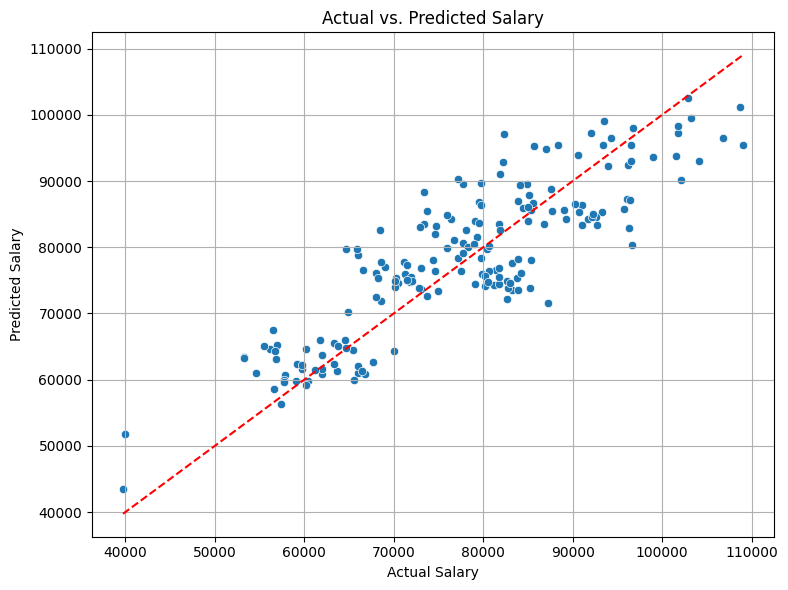

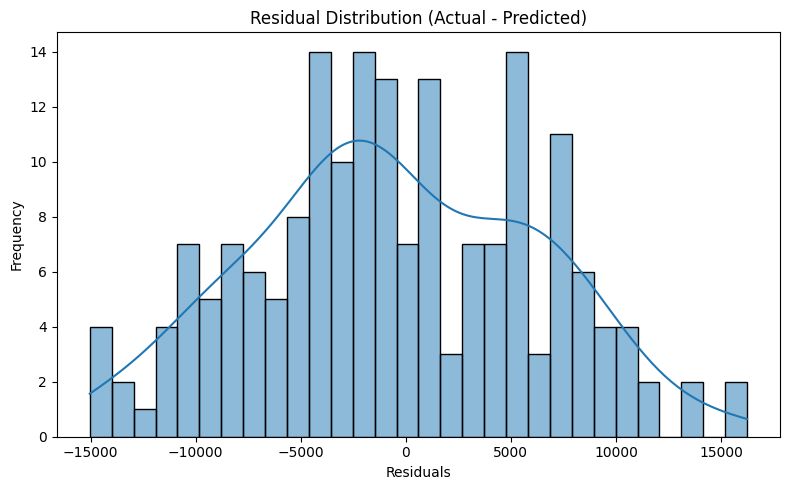

In [48]:
# Visualization of Model Predictions vs. Actual
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = grid.predict(X_test)

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salary")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


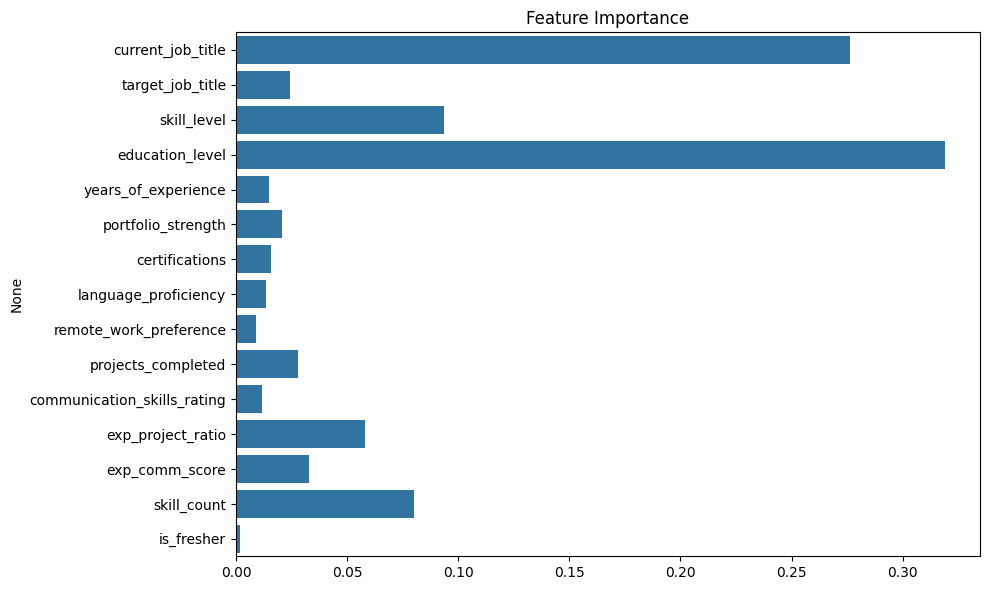

In [49]:
importances = grid.best_estimator_.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [50]:
# Classification on entire preprocessed dataset
print("\n Career Transition Model")
X_cls = df.drop(['estimated_salary_usd', 'target_job_title'], axis=1)
y_cls = df['target_job_title']
feature_columns = X_cls.columns.tolist()
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
career_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    class_weight='balanced'
)

career_clf.fit(X_train_cls, y_train_cls)
y_pred_cls = career_clf.predict(X_test_cls)
print("Classification Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Classification Report:\n", classification_report(y_test_cls, y_pred_cls))



 Career Transition Model
Classification Accuracy: 0.9891891891891892
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00        39
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00        26
           5       0.98      1.00      0.99        41
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00        30

    accuracy                           0.99       185
   macro avg       0.62      0.62      0.62       185
weighted avg       0.98      0.99      0.99       185



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

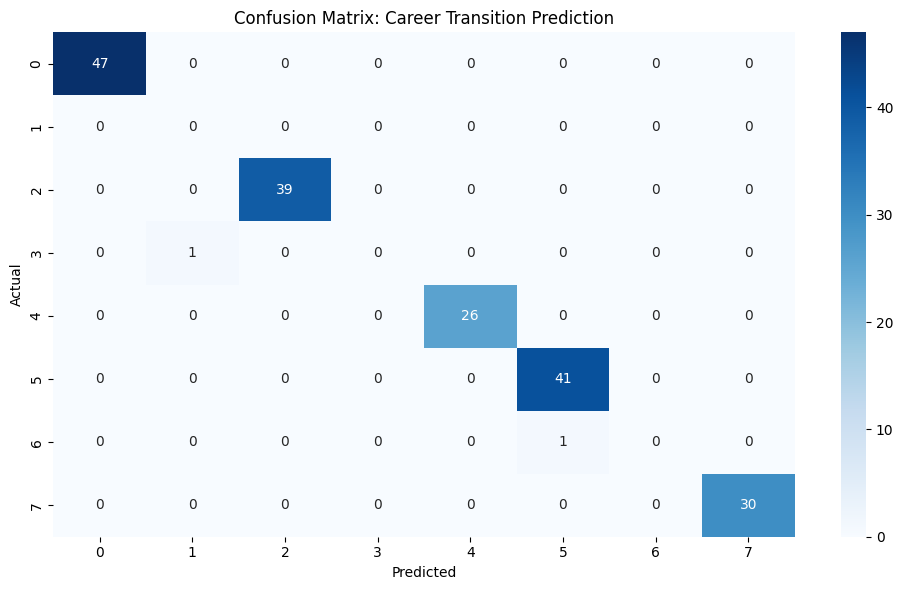

In [51]:
# Confusion Matrix Heatmap
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Career Transition Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()




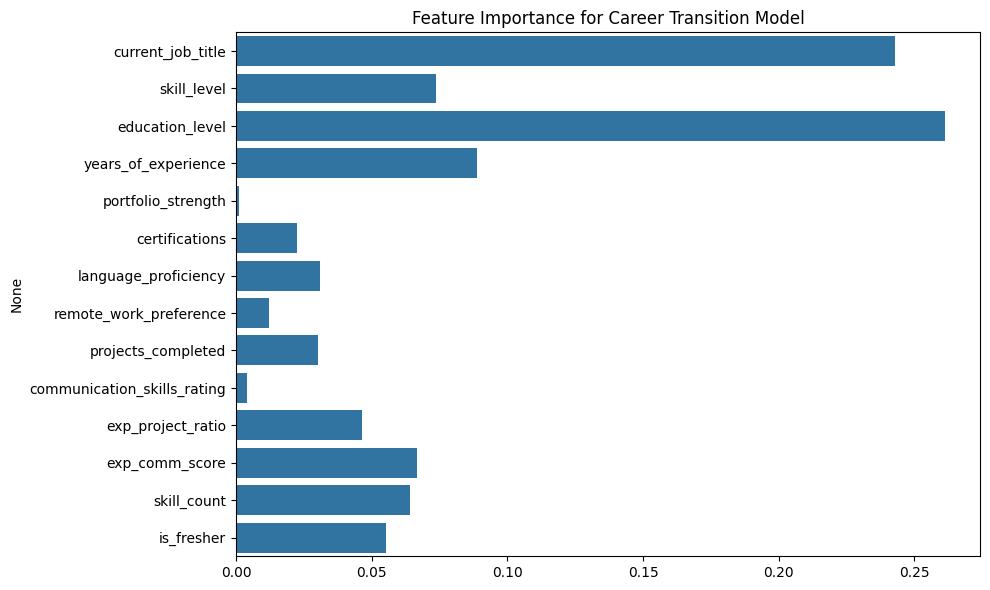

In [52]:
# Feature Importance
cls_importances = career_clf.feature_importances_
cls_features = X_cls.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=cls_importances, y=cls_features)
plt.title('Feature Importance for Career Transition Model')
plt.tight_layout()
plt.show()


In [54]:
import pickle
import json
# 1) Salary prediction model
with open("salary_model.pkl", "wb") as f:
    pickle.dump(grid.best_estimator_, f)

# 2) Career transition model
with open("career_recommender.pkl", "wb") as f:
    pickle.dump(career_clf, f)

# 3) Scaler for numeric features
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
# Job title encoders
joblib.dump(le_current_job, "current_job_title_encoder.pkl")
joblib.dump(le_target_job, "target_job_title_encoder.pkl")
# Save feature column order
with open("feature_columns_salary.json", "w") as f:
    json.dump(list(X.columns), f)
print("✅ All models, encoders, and feature columns saved successfully.")
# Save feature columns for career recommender model
with open("feature_columns_career.json", "w") as f:
    json.dump(list(X_cls.columns), f)



✅ All models, encoders, and feature columns saved successfully.
